## Load Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
## TRAIN
df = pd.read_csv("TRAIN.csv") # # (164575, 34)

## VariablesUsed
var = pd.read_csv("VariablesUsed.csv") 
varU = var.loc[var.used] # (32, 4)

## Response Variables
res = df.iloc[:,-2:] # (164575, 2) 

In [3]:
df.head()

,LID,MRP,CHANNEL,SELLER,ORATE,CRATE,OUPB,OLTERM,ODATE,FPD,...,OCCSTAT,STATE,MSA,ZIP,MIP,CLDS,MIT,RMI,FORECLOSED,NMONTHS
0,8.118470e+11,3/1/2000,C,Suntrust Mortgage Inc.,8.375,8.375,58000,360,7/1/1999,9/1/1999,...,P,OK,36420,730,NaN,0,NaN,N,False,12
1,9.288980e+11,2/1/2000,C,Amtrust Bank,7.500,7.500,204000,180,12/1/1999,2/1/2000,...,P,WA,48300,988,NaN,0,NaN,N,False,21
2,2.229740e+11,1/1/2000,C,"Jpmorgan Chase Bank, Na",7.750,7.750,181000,360,12/1/1999,2/1/2000,...,P,VA,40060,238,30.0,0,1.0,N,False,54
3,5.939500e+11,2/1/2000,B,"Bank Of America, N.A.",8.625,8.625,135000,360,1/1/2000,3/1/2000,...,P,AZ,38060,852,30.0,0,2.0,N,False,16
4,6.773390e+11,2/1/2000,C,Other,7.750,7.750,189000,360,12/1/1999,2/1/2000,...,P,IN,29140,479,NaN,0,NaN,N,False,14


In [7]:
sum(df.FORECLOSED)

2247

In [8]:
df.shape

(164575, 34)

In [4]:
varU

,abbreviated_name,dtype,isdate,used
1,LID,object,0,True
2,MRP,object,1,True
3,CHANNEL,object,0,True
4,SELLER,object,0,True
7,ORATE,np.float64,0,True
8,CRATE,np.float64,0,True
9,OUPB,np.float64,0,True
12,OLTERM,np.float64,0,True
13,ODATE,object,1,True
14,FPD,object,1,True


## Dropping Useless Features

In [5]:
## Drop Highly Correlated features
corrF =  df.iloc[:,:-2].corr().abs()
upper = corrF.where(np.triu(np.ones(corrF.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('drop feature:',to_drop)
## Update Data for Regression
dfR = df
dfR.drop(to_drop, axis=1, inplace=True)

drop feature: ['CRATE', 'TMTLM', 'RMTM']


In [6]:
## Drop Low Correlated features with Response Variables
corrR =  dfR.iloc[:,:-2].corrwith(dfR.iloc[:,-1]).abs()
to_drop = ['LID','CLDS']
print('drop feature:',to_drop)
## Update Data for Regression
dfR.drop(to_drop, axis=1, inplace=True)

drop feature: ['LID', 'CLDS']


## Replace Nan Values

In [ ]:
## Replace Nan with column means
dfR_m = dfR.iloc[:,:-2].fillna(dfR.iloc[:,:-2].mean())
corrR_m =  dfR_m.corrwith(dfR.iloc[:,-1]).abs()
## Replace Nan with 0
dfR_0 = dfR.iloc[:,:-2].fillna(0)
corrR_0 = dfR_0.corrwith(dfR.iloc[:,-1]).abs()
## Choose replace method with higher correlation with y
corrM = pd.DataFrame({'corrR_m':corrR_m,'corrR0':corrR_0})
for i in corrM.index:
    if corrM.loc[i,'corrR_m'] <= corrM.loc[i,'corrR0']:
        dfR[i] = dfR[i].fillna(0)
    else:
        dfR[i] = dfR[i].fillna(dfR[i].mean())

## Visualize and Convert Features

In [9]:
dfR.columns

Index(['MRP', 'CHANNEL', 'SELLER', 'ORATE', 'OUPB', 'OLTERM', 'ODATE', 'FPD',
       'LA', 'MDATE', 'LOTV', 'CLTV', 'NB', 'DTI', 'BCSAO', 'CBCSAO', 'FTHBI',
       'LP', 'PTYPE', 'NUNITS', 'OCCSTAT', 'STATE', 'MSA', 'ZIP', 'MIP', 'MIT',
       'RMI', 'FORECLOSED', 'NMONTHS'],
      dtype='object')

<AxesSubplot:xlabel='MRP', ylabel='NMONTHS'>

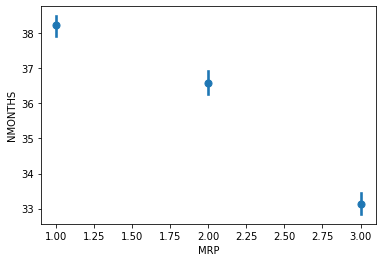

In [10]:
MRP = pd.to_datetime(dfR["MRP"])
MRP = MRP.dt.month
dfC = pd.DataFrame({'MRP':MRP,'NMONTHS':dfR.NMONTHS})
sns.regplot(x='MRP', y='NMONTHS',data=dfC,fit_reg=False,x_bins=3)

In [11]:
# dfR.CHANNEL.hist()
dfC['CHANNEL']=dfR.CHANNEL
dfC['CHANNEL']=dfC['CHANNEL'].astype('category')
# sns.regplot(x='CHANNEL', y='NMONTHS',data=dfC, fit_reg=False,x_bins=3)
dfC['SELLER']=dfR.SELLER
dfC['SELLER']=dfC['SELLER'].astype('category')
dfC['FTHBI']=dfR.FTHBI
dfC['FTHBI']=dfC['FTHBI'].astype('category')
dfC['LP']=dfR.LP
dfC['LP']=dfC['LP'].astype('category')
dfC['PTYPE']=dfR.PTYPE
dfC['PTYPE']=dfC['PTYPE'].astype('category')
dfC['NUNITS']=dfR.NUNITS
dfC['NUNITS']=dfC['NUNITS'].astype('category')
dfC['OCCSTAT']=dfR.OCCSTAT
dfC['OCCSTAT']=dfC['OCCSTAT'].astype('category')
dfC['STATE']=dfR.STATE
dfC['STATE']=dfC['STATE'].astype('category')
dfC['RMI']=dfR.RMI
dfC['RMI']=dfC['RMI'].astype('category')
# replace with numeric values
cat_columns = dfC.select_dtypes(['category']).columns
dfC[cat_columns] = dfC[cat_columns].apply(lambda x: x.cat.codes)

<AxesSubplot:xlabel='CHANNEL', ylabel='NMONTHS'>

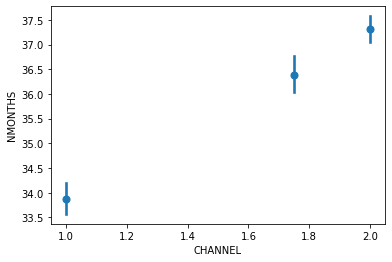

In [12]:
dfC["CHANNEL"] = dfC.CHANNEL.replace(0,1.75)
sns.regplot(x='CHANNEL', y='NMONTHS',data=dfC,fit_reg=False,x_bins=4)

<AxesSubplot:xlabel='ORATE', ylabel='NMONTHS'>

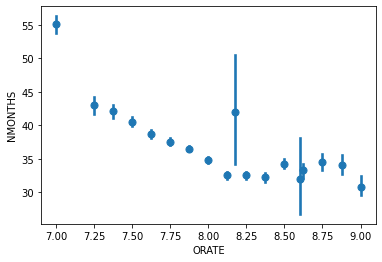

In [13]:
dfC['ORATE'] = dfR.ORATE
sns.regplot(x='ORATE', y='NMONTHS',data=dfC, fit_reg=False,x_bins=50)

<AxesSubplot:xlabel='OUPB', ylabel='NMONTHS'>

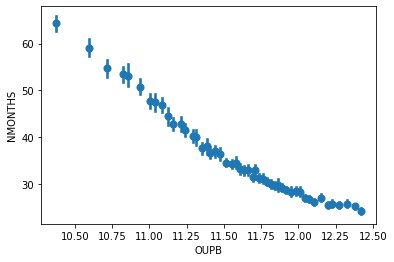

In [14]:
dfC["OUPB"]=np.log(dfR.OUPB)
sns.regplot(x='OUPB', y='NMONTHS',data=dfC, fit_reg=False,x_bins=50)

<AxesSubplot:xlabel='OLTERM', ylabel='NMONTHS'>

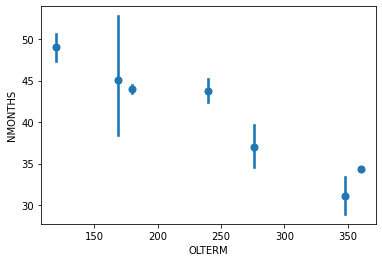

In [15]:
dfC['OLTERM'] = dfR.OLTERM
sns.regplot(x='OLTERM', y='NMONTHS',data=dfC,fit_reg=False,x_bins=200)

<AxesSubplot:xlabel='ODATE', ylabel='NMONTHS'>

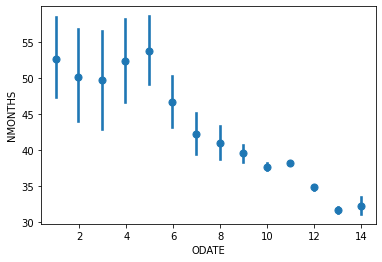

In [16]:
dfR.ODATE.value_counts()
ODATE_dM = pd.to_datetime(dfR["ODATE"])-min(pd.to_datetime(dfR["ODATE"]))
dfC["ODATE"] = ODATE_dM / np.timedelta64(1, 'M')
sns.regplot(x="ODATE", y='NMONTHS',data=dfC,fit_reg=False,x_bins=1000)

<AxesSubplot:xlabel='FPD', ylabel='NMONTHS'>

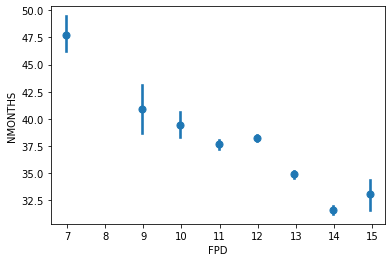

In [17]:
dfR.FPD.value_counts()
FPD_dM = pd.to_datetime(dfR["FPD"])-min(pd.to_datetime(dfR["FPD"]))
dfC["FPD"] = FPD_dM / np.timedelta64(1, 'M')
sns.regplot(x="FPD", y='NMONTHS',data=dfC,fit_reg=False,x_bins=100)

In [18]:
dfC.FPD.corr(dfC.ODATE)
dfC.drop('FPD', axis=1, inplace=True)

<AxesSubplot:xlabel='LA', ylabel='NMONTHS'>

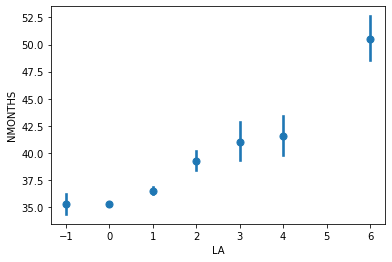

In [19]:
dfC['LA'] = dfR.LA
sns.regplot(x="LA", y='NMONTHS',data=dfC,fit_reg=False,x_bins=100)

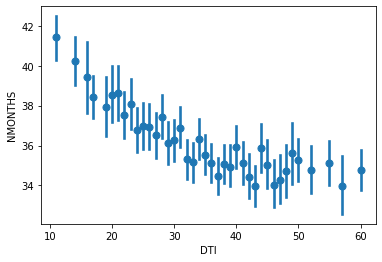

In [20]:
# set(dfR.DTI.isna())
sns.regplot(x='DTI', y="NMONTHS",data=dfR,fit_reg=False,x_bins=50)
dfC["DTI"] = dfR.DTI.fillna(dfR.DTI.mean())

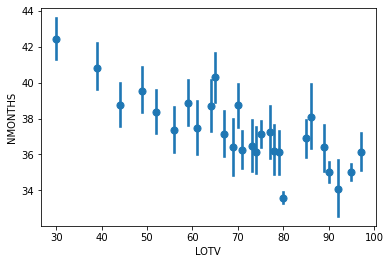

In [21]:
# set(dfR.DTI.isna())
sns.regplot(x="LOTV", y="NMONTHS",data=dfR,fit_reg=False,x_bins=50)
dfC["LOTV"] = dfR.LOTV.fillna(dfR.LOTV.mean())

## Non-Trending or Repeatative Features

In [22]:
MDATE = dfR.MDATE.astype('string')
for i in MDATE:
    if len(i)<6:
        MDATE[i] = '0'+i
MDATE = pd.to_datetime(MDATE,format="%m%Y")
# MDATE=np.exp(dfC.MDATE)
# sns.regplot(x="MDATE", y='NMONTHS',data=dfC,fit_reg=False)
# dfC.MDATE.value_counts()

<AxesSubplot:xlabel='CLTV', ylabel='NMONTHS'>

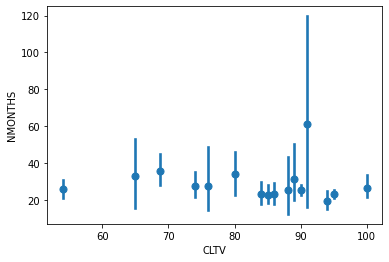

In [23]:
sns.regplot(x="CLTV", y="NMONTHS",data=dfR.loc[dfR.CLTV>0],fit_reg=False,x_bins=50)

<AxesSubplot:xlabel='CBCSAO', ylabel='NMONTHS'>

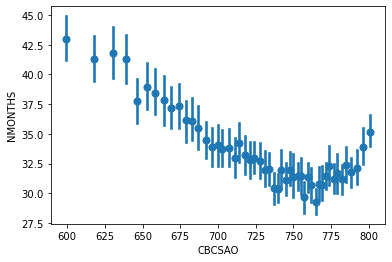

In [24]:
sns.regplot(x="CBCSAO", y="NMONTHS",data=dfR.loc[dfR.CBCSAO>0],fit_reg=False,x_bins=50)
# highly correlated with BCSAO

In [25]:
MIT = dfR.MIT.dropna()
# MIT = dfR.MIT.fillna(np.mean(MIT))
# sns.regplot(x="MIT", y="NMONTHS",data=dfR.loc[dfR.MIT.dropna()],fit_reg=False)

## Non-Linear Trending Features

In [26]:
a=np.array(dfR.NB==1)
b=np.array(dfR.NB==4)
a+b

array([False,  True,  True, ..., False, False, False])

<AxesSubplot:xlabel='NB', ylabel='NMONTHS'>

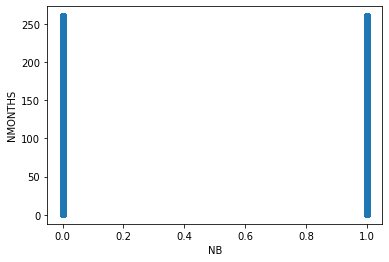

In [27]:
# sns.regplot(x='NB', y="NMONTHS",data=dfR,fit_reg=False,x_bins=500)
NB1 = pd.Series(dfR.NB==2,dtype='int')
NB4 = pd.Series(dfR.NB==4,dtype='int')
sns.regplot(x=NB1, y="NMONTHS",data=dfR,fit_reg=False)
# sns.regplot(x=NB4, y="NMONTHS",data=dfR,fit_reg=False)

<AxesSubplot:xlabel='BCSAO', ylabel='NMONTHS'>

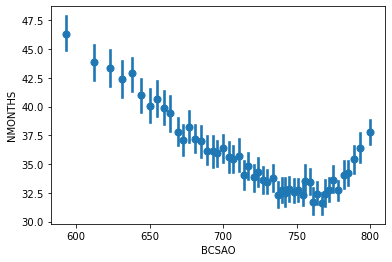

In [28]:
sns.regplot(x='BCSAO', y="NMONTHS",data=dfR,fit_reg=False,x_bins=50)

<AxesSubplot:xlabel='SELLER', ylabel='NMONTHS'>

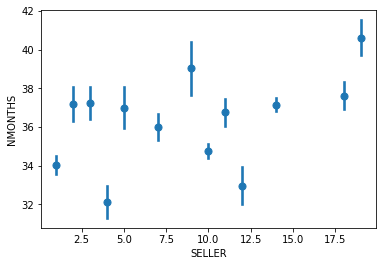

In [29]:
sns.regplot(x='SELLER', y='NMONTHS',data=dfC,fit_reg=False,x_bins=22)

<AxesSubplot:xlabel='MSA', ylabel='NMONTHS'>

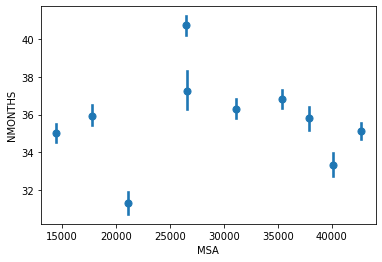

In [30]:
# MSA=np.log(dfR.loc[MSA>0])
# sns.regplot(x=MSA, y="NMONTHS",data=dfR,fit_reg=False,x_bins=50)
MSA=dfR.MSA.replace(0,np.mean(df.MSA))
# MSA=np.log(MSA)
sns.regplot(x=MSA, y="NMONTHS",data=dfR,fit_reg=False,x_bins=10)

<AxesSubplot:xlabel='ZIP', ylabel='NMONTHS'>

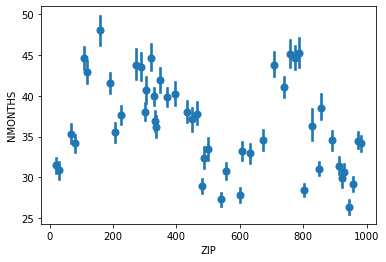

In [31]:
sns.regplot(x="ZIP", y="NMONTHS",data=dfR,fit_reg=False,x_bins=50)

<AxesSubplot:xlabel='MIP', ylabel='NMONTHS'>

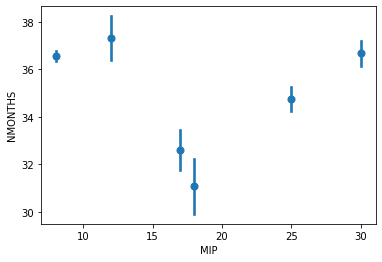

In [32]:
MIP = dfR.MIP.fillna(0)
MIP = MIP.replace(0,np.mean(MIP))
sns.regplot(x=MIP, y="NMONTHS",data=dfR,fit_reg=False,x_bins=50)

## Cross-Validation with Linear Regression

In [33]:
# dfC["NMONTHS"] = dfR.NMONTHS
dfC.columns

Index(['MRP', 'NMONTHS', 'CHANNEL', 'SELLER', 'FTHBI', 'LP', 'PTYPE', 'NUNITS',
       'OCCSTAT', 'STATE', 'RMI', 'ORATE', 'OUPB', 'OLTERM', 'ODATE', 'LA',
       'DTI', 'LOTV'],
      dtype='object')

In [34]:
# rescale response variable
dfC["NMONTHS"]=df.NMONTHS

# train-test 70-30 split
df_train, df_test = train_test_split(dfC, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)
# rescale the features
# scaler = MinMaxScaler()
# # apply scaler() to all the numeric columns 
# scalable_vars = ['ORATE', 'OUPB', 'OLTERM', 'ODATE', 'DTI','LOTV']
# df_train[scalable_vars] = scaler.fit_transform(df_train[scalable_vars])
# df_test[scalable_vars] = scaler.fit_transform(df_test[scalable_vars])

# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('NMONTHS')
X_train = df_train

y_test = df_test.pop('NMONTHS')
X_test = df_test

In [35]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=17)             
rfe = rfe.fit(X_train, y_train)
### tuples of (feature name, whether selected, ranking (> 1 for non-selected features))
# list(zip(X_train.columns,rfe.support_,rfe.ranking_))

In [36]:
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.10260699504898196


# Modity TEST DATA

In [37]:
TEST = pd.read_csv("TEST.csv") # (82288, 32)
TEST["MRP"]=pd.to_datetime(TEST["MRP"]).dt.month
# dfR.CHANNEL.hist()
TEST['CHANNEL']=dfR.CHANNEL
dfC['CHANNEL']=dfC['CHANNEL'].astype('category')
# sns.regplot(x='CHANNEL', y='NMONTHS',data=dfC, fit_reg=False,x_bins=3)
dfC['SELLER']=dfR.SELLER
dfC['SELLER']=dfC['SELLER'].astype('category')
dfC['FTHBI']=dfR.FTHBI
dfC['FTHBI']=dfC['FTHBI'].astype('category')
dfC['LP']=dfR.LP
dfC['LP']=dfC['LP'].astype('category')
dfC['PTYPE']=dfR.PTYPE
dfC['PTYPE']=dfC['PTYPE'].astype('category')
dfC['NUNITS']=dfR.NUNITS
dfC['NUNITS']=dfC['NUNITS'].astype('category')
dfC['OCCSTAT']=dfR.OCCSTAT
dfC['OCCSTAT']=dfC['OCCSTAT'].astype('category')
dfC['STATE']=dfR.STATE
dfC['STATE']=dfC['STATE'].astype('category')
dfC['RMI']=dfR.RMI
dfC['RMI']=dfC['RMI'].astype('category')
# replace with numeric values
cat_columns = dfC.select_dtypes(['category']).columns
dfC[cat_columns] = dfC[cat_columns].apply(lambda x: x.cat.codes)

In [38]:


TEST.head()

,LID,MRP,CHANNEL,SELLER,ORATE,CRATE,OUPB,OLTERM,ODATE,FPD,...,PTYPE,NUNITS,OCCSTAT,STATE,MSA,ZIP,MIP,CLDS,MIT,RMI
0,7.940000e+11,3,C,"Gmac Mortgage, Llc",8.625,8.625,111000,360,2/1/2000,4/1/2000,...,SF,1,P,MI,22420,484,NaN,0,NaN,N
1,2.770000e+11,1,C,"Citimortgage, Inc.",8.250,8.250,105000,360,11/1/1999,1/1/2000,...,MH,1,P,NE,30700,684,17.0,0,1.0,N
2,5.070000e+11,1,C,Other,7.375,7.375,130000,180,11/1/1999,1/1/2000,...,SF,1,P,KS,0,679,NaN,0,NaN,N
3,4.930000e+11,3,B,"Jpmorgan Chase Bank, Na",8.500,8.500,58000,180,1/1/2000,3/1/2000,...,SF,1,I,TX,26420,770,NaN,0,NaN,N
4,8.430000e+11,2,C,Netbank Funding Services,7.875,7.875,170000,360,1/1/2000,3/1/2000,...,SF,1,P,IL,16980,606,NaN,0,NaN,N


In [39]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [40]:
clf = RandomForestClassifier(random_state=10)
print('Acc:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

Acc: 0.03535526834109727
F1: nan
ROC AUC: nan


In [41]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
print('R2_mean',scores.mean())
print(sum(abs(y_pred-y_test))/len(y_test))

R2_mean 0.10146900515304687
18.974620977920125
